In [1168]:
import json
import requests
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt  # matplotlib is not installed automatically
from datetime import datetime
import warnings
warnings.filterwarnings("ignore")

from osgeo import gdal
import rioxarray
import rasterio as rio

import xarray as xr

In [1169]:
# network_name = 'various-geographic-locations'
# network_name = 'California'
network_name = 'vegetation-type'
coordinate = 11

home_dir = r"G:\Araki\SMSigxSMAP"
input_path = r"1_data"
appeears_path = r"APPEEARS_subsetting"
SMAPL3_path = r"SPL3SMP_E"
SMAP_ANC_path = r"SMAP_L1_L3_ANC_STATIC"
SMAPL4_path = r"SPL4SMGP"
SMAPL4_grid_path = r"SMAPL4SMGP_EASEreference"
MODIS_path = r"MOD15A2H"
PET_path = r"PET"

output_path = r"3_data_out\exp_plots"

# success: 0, 2, 7, 8, 10, 
# ['Missouri - cropland', 'Wisconsin - cropland', 'Texas - Shrublands',  'Oklahoma - Shrublands', 'South Sudan - Woody savannah']


# succsss: ["Central_valley", "China (Mid-lat humid)", "South Dacota (Mid-lat dry)", "Argentina (Mid-lat dry)", "Russia (Mid-lat humid)"]
# ["Northern Australia 2", "Congo", "Canada", "South America", "Chile", "Argentina 2"]
# success: [0][4, 6, 8, 9][0, 2, 4, 5, 9, 10]

# succsss: ["Central_valley", "China (Mid-lat humid)", "South Dacota (Mid-lat dry)", "Argentina (Mid-lat dry)", "Russia (Mid-lat humid)"]
# ["Northern Australia 2", "Congo", "Canada", "South America", "Chile", "Argentina 2"]
# success: [0][4, 6, 8, 9][0, 2, 4, 5, 9, 10]

In [1171]:
coordinates

[{'id': '0',
  'category': 'Missouri - cropland',
  'latitude': 38.349458,
  'longitude': -92.11364},
 {'id': '1',
  'category': 'Kentucky - cropland',
  'latitude': 38.7471343,
  'longitude': -84.557543},
 {'id': '2',
  'category': 'Wisconsin - cropland',
  'latitude': 43.778573,
  'longitude': -90.72817},
 {'id': '3',
  'category': 'Ontario - grasslands',
  'latitude': 54.24085,
  'longitude': -87.1687431},
 {'id': '4',
  'category': 'WVirginia - deciduous forest',
  'latitude': 37.95311,
  'longitude': -82.16426},
 {'id': '5',
  'category': 'Arkansas - deciduous forest',
  'latitude': 33.91957,
  'longitude': -92.5154},
 {'id': '6',
  'category': 'Louisiana - grasslands',
  'latitude': 29.97784,
  'longitude': -91.34057},
 {'id': '7',
  'category': 'Texas - Shrublands',
  'latitude': 32.067705,
  'longitude': -94.72778},
 {'id': '8',
  'category': 'Oklahoma - Shrublands',
  'latitude': 34.650496,
  'longitude': -95.59172},
 {'id': '9',
  'category': 'SCarolina - Shrublands',
  'lati

## Read and process data

### Read request json

In [1170]:
file_path = os.path.join(home_dir, input_path, appeears_path, network_name, f'point-request-{network_name}-request.json')
with open(file_path, 'r') as infile:
    request_content = json.load(infile)

coordinates = request_content['params']['coordinates']
print(f'Total sample points: {len(coordinates)}')
target_lat = coordinates[coordinate]['latitude']
target_lon = coordinates[coordinate]['longitude']
target_station = coordinates[coordinate]['category']
print(f'Currently processing station #{coordinate}: {target_station}')

output_path2 = os.path.join(home_dir, output_path, target_station)
if not os.path.exists(output_path2):
    os.makedirs(output_path2)

Total sample points: 12


IndexError: list index out of range

### SMAP L3

In [ ]:
file_path = os.path.join(home_dir, input_path, appeears_path, network_name, f'point-request-{network_name}-SPL3SMP-E-005-results.csv')
SMAPL3_pt_sample = pd.read_csv(file_path)
SMAPL3_pt_sample = SMAPL3_pt_sample[(SMAPL3_pt_sample['Latitude'] == target_lat) & (SMAPL3_pt_sample['Longitude'] == target_lon)].copy()

df_ts_smap_am = SMAPL3_pt_sample[['Date', 'SPL3SMP_E_005_Soil_Moisture_Retrieval_Data_AM_soil_moisture','SPL3SMP_E_005_Soil_Moisture_Retrieval_Data_AM_retrieval_qual_flag']].copy()
df_ts_smap_am['Date'] = pd.to_datetime(df_ts_smap_am['Date'])
df_ts_smap_am.set_index('Date', inplace=True)
bad_data_idx_smap = df_ts_smap_am[(df_ts_smap_am['SPL3SMP_E_005_Soil_Moisture_Retrieval_Data_AM_retrieval_qual_flag'] != 0.0) & (df_ts_smap_am['SPL3SMP_E_005_Soil_Moisture_Retrieval_Data_AM_retrieval_qual_flag'] != 8.0)].index
df_ts_smap_am.drop(bad_data_idx_smap, inplace=True)
df_ts_smap_am_daily = df_ts_smap_am['SPL3SMP_E_005_Soil_Moisture_Retrieval_Data_AM_soil_moisture'].resample('D', axis=0).mean()

df_ts_smap_pm = SMAPL3_pt_sample[['Date', 'SPL3SMP_E_005_Soil_Moisture_Retrieval_Data_PM_soil_moisture_pm','SPL3SMP_E_005_Soil_Moisture_Retrieval_Data_PM_retrieval_qual_flag_pm']].copy()
df_ts_smap_pm['Date'] = pd.to_datetime(df_ts_smap_pm['Date'])
df_ts_smap_pm.set_index('Date', inplace=True)
bad_data_idx_smap = df_ts_smap_pm[(df_ts_smap_pm['SPL3SMP_E_005_Soil_Moisture_Retrieval_Data_PM_retrieval_qual_flag_pm'] != 0.0) & (df_ts_smap_pm['SPL3SMP_E_005_Soil_Moisture_Retrieval_Data_PM_retrieval_qual_flag_pm'] != 8.0)].index
df_ts_smap_pm.drop(bad_data_idx_smap, inplace=True)
df_ts_smap_pm_daily = df_ts_smap_pm['SPL3SMP_E_005_Soil_Moisture_Retrieval_Data_PM_soil_moisture_pm'].resample('D', axis=0).mean()

df_ts_sync = pd.merge(df_ts_smap_am_daily, df_ts_smap_pm_daily, how='inner', left_index=True, right_index=True)
df_ts_sync['soil_moisture_smapL3'] = df_ts_sync[['SPL3SMP_E_005_Soil_Moisture_Retrieval_Data_AM_soil_moisture','SPL3SMP_E_005_Soil_Moisture_Retrieval_Data_PM_soil_moisture_pm']].mean(axis=1, skipna=True)
df_ts_sync['soil_moisture_smapL3'] = df_ts_sync['soil_moisture_smapL3'].resample('D', axis=0).mean()

### SMAPL4

In [ ]:
file_path = os.path.join(home_dir, input_path, appeears_path, network_name, f'point-request-{network_name}-P-SPL4SMGP-006-results.csv')
SMAPL4_pt_sample = pd.read_csv(file_path)
SMAPL4_pt_sample = SMAPL4_pt_sample[(SMAPL4_pt_sample['Latitude'] == target_lat) & (SMAPL4_pt_sample['Longitude'] == target_lon)].copy()

# print(SMAPL4_pt_sample.columns)

# SMAPL4_pt_sample[['SPL4SMGP_006_Geophysical_Data_precipitation_total_surface_flux_0', 
#                   'SPL4SMGP_006_Geophysical_Data_precipitation_total_surface_flux_1',
#                   'SPL4SMGP_006_Geophysical_Data_precipitation_total_surface_flux_2',
#                   'SPL4SMGP_006_Geophysical_Data_precipitation_total_surface_flux_3',
#                   'SPL4SMGP_006_Geophysical_Data_precipitation_total_surface_flux_4',
#                   'SPL4SMGP_006_Geophysical_Data_precipitation_total_surface_flux_5',
#                   'SPL4SMGP_006_Geophysical_Data_precipitation_total_surface_flux_6',
#                   'SPL4SMGP_006_Geophysical_Data_precipitation_total_surface_flux_7']].plot()

# ? Where is data converted to daily from hourly? 

df_ts_smap_precip = SMAPL4_pt_sample[['Date', 'SPL4SMGP_006_Geophysical_Data_precipitation_total_surface_flux_0']].copy()
df_ts_smap_precip = df_ts_smap_precip.rename({'SPL4SMGP_006_Geophysical_Data_precipitation_total_surface_flux_0': 'precip'}, axis='columns')
df_ts_smap_precip['Date'] = pd.to_datetime(df_ts_smap_precip['Date'])
df_ts_smap_precip.set_index('Date', inplace=True)
df_ts_smap_precip


,precip
Date,
2015-03-31,7.320000e-05
2015-04-01,1.000000e-06
2015-04-02,0.000000e+00
2015-04-03,0.000000e+00
2015-04-04,1.000000e-07
...,...
2022-04-26,2.200000e-06
2022-04-27,5.560000e-05
2022-04-28,3.160000e-05


Convert precipitation from kg/m2/s to mm/day -> 1 kg/m2/s = 86400 mm/day

In [ ]:
df_ts_smap_precip = df_ts_smap_precip * 86400

In [ ]:
df_ts_sync = pd.merge(df_ts_sync, df_ts_smap_precip, how='inner', left_index=True, right_index=True)

noprecip = df_ts_smap_precip['precip'] < 0.00002
df_ts_sync['noprecip'] = noprecip

df_ts_sync.head()

,SPL3SMP_E_005_Soil_Moisture_Retrieval_Data_AM_soil_moisture,SPL3SMP_E_005_Soil_Moisture_Retrieval_Data_PM_soil_moisture_pm,soil_moisture_smapL3,precip,noprecip
Date,,,,,
2015-04-03,0.066951,NaN,0.066951,0.00000,True
2015-04-04,NaN,NaN,NaN,0.00864,False
2015-04-05,NaN,0.039093,0.039093,0.00000,True
2015-04-06,0.072724,NaN,0.072724,0.00000,True
2015-04-07,NaN,0.041878,0.041878,0.02592,False


In [ ]:
df_ts_sync.tail()

,SPL3SMP_E_005_Soil_Moisture_Retrieval_Data_AM_soil_moisture,SPL3SMP_E_005_Soil_Moisture_Retrieval_Data_PM_soil_moisture_pm,soil_moisture_smapL3,precip,noprecip
Date,,,,,
2022-04-25,0.142461,NaN,0.142461,0.75168,False
2022-04-26,NaN,0.110525,0.110525,0.19008,False
2022-04-27,0.175774,NaN,0.175774,4.80384,False
2022-04-28,NaN,NaN,NaN,2.73024,False
2022-04-29,NaN,0.081906,0.081906,0.81216,False


<Axes: xlabel='Date'>

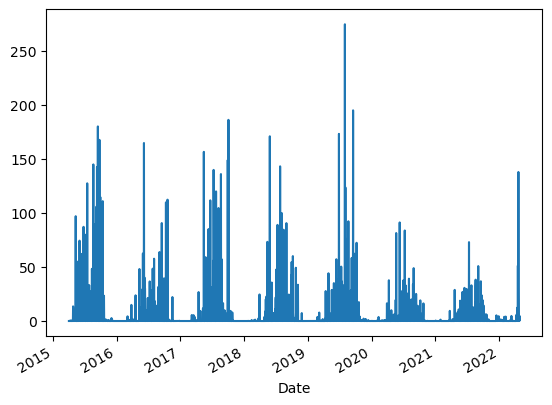

In [ ]:
df_ts_sync['precip'].plot()

### PET

Get the point-sampled PET data beforehand by running '0_code\singerPET_create_datarods_v3.py'

In [ ]:
file_path = os.path.join(home_dir, input_path, PET_path, target_station)
file_list = os.listdir(file_path)

print(file_list)
PET = pd.read_csv(os.path.join(file_path, file_list[0]), header=None)
day_num = PET.index.to_numpy()
year = file_list[0][-8:-4]
PET['Date'] = pd.to_datetime(PET.index, unit='D', origin=pd.Timestamp(year))
PET.set_index('Date', inplace=True)

for i, file in enumerate(file_list):
    PET = pd.read_csv(os.path.join(file_path, file), header=None)
    year = file[-8:-4]
    PET['Date'] = pd.to_datetime(PET.index, unit='D', origin=pd.Timestamp(year))
    PET.set_index('Date', inplace=True)
    if i==0:
        ds_PET = PET
    else:
        ds_PET = pd.concat([ds_PET, PET])
ds_PET = ds_PET.sort_index()
ds_PET = ds_PET.rename(columns = {0:'PET'})
ds_PET

['dPET_2015.txt', 'dPET_2016.txt', 'dPET_2017.txt', 'dPET_2018.txt', 'dPET_2019.txt', 'dPET_2020.txt', 'dPET_2021.txt']


,PET
Date,
2015-01-01,5.86834
2015-01-02,6.69180
2015-01-03,6.96882
2015-01-04,6.58846
2015-01-05,6.06167
...,...
2021-12-27,6.75190
2021-12-28,6.18855
2021-12-29,6.47623


In [ ]:
ds_synced = pd.merge(df_ts_sync[['soil_moisture_smapL3', 'precip']], ds_PET, how='inner', left_index=True, right_index=True)
ds_synced = ds_synced.rename({'soil_moisture_smapL3': 'soil_moisture_daily'}, axis='columns')
ds_synced

,soil_moisture_daily,precip,PET
Date,,,
2015-04-03,0.066951,0.00000,5.81677
2015-04-04,NaN,0.00864,5.61718
2015-04-05,0.039093,0.00000,5.76695
2015-04-06,0.072724,0.00000,5.87288
2015-04-07,0.041878,0.02592,6.63927
...,...,...,...
2021-12-27,0.104117,1.04544,6.75190
2021-12-28,0.127644,3.06720,6.18855
2021-12-29,NaN,4.41504,6.47623


In [ ]:
ds_synced.tail()

,soil_moisture_daily,precip,PET
Date,,,
2021-12-27,0.104117,1.04544,6.75190
2021-12-28,0.127644,3.06720,6.18855
2021-12-29,NaN,4.41504,6.47623
2021-12-30,0.096705,2.38464,6.36856
2021-12-31,0.114625,0.51840,5.17677


## Calculate dSdt

In [ ]:
# Thresholds
lower_quantile_thresh = 0.25
upper_quantile_thresh = 0.75
precip_thresh = 0.00002

In [ ]:
precip_mask = ds_synced['precip'].where(ds_synced['precip'] < precip_thresh)
no_sm_record_but_precip_present = ds_synced['precip'].where((precip_mask.isnull()) & (ds_synced['soil_moisture_daily'].isnull()))
# ds_synced['sm_for_dS_calc'] = ds_synced['soil_moisture_daily'].where(no_sm_record_but_precip_present.isnull(), 9999)

# Allow detecting soil moisture increment even if there is no SM data in between before/after rainfall event
# NaN data is allowed up to 10 days
ds_synced['sm_for_dS_calc'] = ds_synced['soil_moisture_daily'].ffill() 

In [ ]:
# Calculate dS
ds_synced['dS'] = ds_synced['sm_for_dS_calc'].bfill(limit=5).diff().where(ds_synced['sm_for_dS_calc'].notnull().shift(periods=+1))

# Drop the dS where  (precipitation is present) && (soil moisture record does not exist)
ds_synced['dS'] = ds_synced['dS'].where((ds_synced['dS'] > -1) & (ds_synced['dS'] < 1))

# Calculate dt
non_nulls = ds_synced['sm_for_dS_calc'].isnull().cumsum()
nan_length = non_nulls.where(ds_synced['sm_for_dS_calc'].notnull()).bfill()+1 - non_nulls +1
ds_synced['dt'] = nan_length.where(ds_synced['sm_for_dS_calc'].isnull()).fillna(1)

# Calculate dS/dt
ds_synced['dSdt'] = ds_synced['dS']/ds_synced['dt']
ds_synced['dSdt'] = ds_synced['dSdt'].shift(periods=-1)


In [ ]:
ds_synced.loc[ds_synced['soil_moisture_daily'].shift(-1).isna(), 'dSdt'] = np.nan

In [ ]:
ds_synced.head()

,soil_moisture_daily,precip,PET,sm_for_dS_calc,dS,dt,dSdt
Date,,,,,,,
2015-04-03,0.066951,0.00000,5.81677,0.066951,NaN,1.0,NaN
2015-04-04,NaN,0.00864,5.61718,0.066951,0.000000,1.0,-0.027858
2015-04-05,0.039093,0.00000,5.76695,0.039093,-0.027858,1.0,0.033631
2015-04-06,0.072724,0.00000,5.87288,0.072724,0.033631,1.0,-0.030846
2015-04-07,0.041878,0.02592,6.63927,0.041878,-0.030846,1.0,0.035568


## Detect significant peak

Adapt https://agupubs.onlinelibrary.wiley.com/doi/10.1002/2017GL072819


- Any positive increment smaller than 5% of the observed range of soil moisture at the site is excluded if it would otherwise truncate a drydown. 
- To avoid noise creating spurious drydowns, identified drydowns were excluded from the analysis when the positive increment preceding the drydown was less than two times the target unbiased root-mean-square difference for SMAP observations (0.08). 
- Of the remaining drydowns, only those that contained more than four SMAP observations were retained.

In [ ]:
# Any positive increment smaller than 5% of the observed range of soil moisture at the site is excluded if it would otherwise truncate a drydown. 
dSdt_thresh = (ds_synced.soil_moisture_daily.max() - ds_synced.soil_moisture_daily.min()) * 0.05

# To avoid noise creating spurious drydowns, identified drydowns were excluded from the analysis when the positive increment preceding the drydown was less than two times the target unbiased root-mean-square difference for SMAP observations (0.08).
target_rmsd = 0.08
dSdt_thresh

0.02082401

In [ ]:
ds_synced.head(15)

,soil_moisture_daily,precip,PET,sm_for_dS_calc,dS,dt,dSdt
Date,,,,,,,
2015-04-03,0.066951,0.00000,5.81677,0.066951,NaN,1.0,NaN
2015-04-04,NaN,0.00864,5.61718,0.066951,0.000000,1.0,-0.027858
2015-04-05,0.039093,0.00000,5.76695,0.039093,-0.027858,1.0,0.033631
2015-04-06,0.072724,0.00000,5.87288,0.072724,0.033631,1.0,-0.030846
2015-04-07,0.041878,0.02592,6.63927,0.041878,-0.030846,1.0,0.035568
2015-04-08,0.077447,0.00000,5.60750,0.077447,0.035568,1.0,NaN
2015-04-09,NaN,0.00000,5.77250,0.077447,0.000000,1.0,-0.038011
2015-04-10,0.039436,0.00000,6.14316,0.039436,-0.038011,1.0,0.026564
2015-04-11,0.066000,0.53568,5.37932,0.066000,0.026564,1.0,NaN


In [ ]:
negative_increments = ds_synced.dSdt < 0

# To avoid noise creating spurious drydowns, identified drydowns were excluded from the analysis when the positive increment preceding the drydown was less than two times the target unbiased root-mean-square difference for SMAP observations (0.08).
positive_increments = ds_synced.dSdt > target_rmsd

In [ ]:

# positive_increments = ds_synced.dS.ffill() > target_rmsd
# TODO: NOT lose drydown starting after NaN

# Negative dSdt preceded with positive dSdt
ds_synced['event_start'] = negative_increments.values & np.concatenate(([False], positive_increments[:-1]))
ds_synced['event_start'][ds_synced['event_start']].index

# drydown_indices = ds_synced.index[negative_increments & pd.Series(np.concatenate(([False], positive_increments[:-1])), index=ds_synced.index)]
# drydown_indices
# sum(negative_increments.values & np.concatenate(([False], positive_increments[:-1])))

DatetimeIndex(['2015-06-09', '2015-07-02', '2015-07-18', '2016-06-19',
               '2016-07-13', '2016-08-02', '2016-08-23', '2016-10-18',
               '2017-04-12', '2017-05-09', '2017-07-07', '2017-07-20',
               '2017-07-31', '2018-05-15', '2018-07-11', '2018-07-23',
               '2019-05-26', '2019-08-06', '2020-04-10', '2020-05-20',
               '2020-05-25', '2020-06-06', '2020-06-30', '2020-07-16',
               '2020-08-02', '2021-05-15', '2021-06-29'],
              dtype='datetime64[ns]', name='Date', freq=None)

In [ ]:
# # iterate through each row to find event end
# precip_thresh = 2
# event_end = np.zeros(ds_synced.shape[0], dtype=bool)
# ds_synced['dS'] = ds_synced['dS'].shift(-1)
# for i in range(1, ds_synced.shape[0]):
#     if ds_synced['event_start'][i]:
#         start_index = i
#         for j in range(i+1, ds_synced.shape[0]):
#             if np.isnan(ds_synced['dS'][j]):
#                 continue
#             if ds_synced['dS'][j] >= dSdt_thresh or ds_synced['precip'][j] > precip_thresh:
#                 event_end[j] = True
#                 break

# # create a new column for event_end
# ds_synced['event_end'] = event_end
# iterate through each row to find event end
precip_thresh = 2
event_end = np.zeros(ds_synced.shape[0], dtype=bool)
# ds_synced['dS'] = ds_synced['dS'].shift(-1)
for i in range(1, ds_synced.shape[0]):
    if ds_synced['event_start'][i]:
        start_index = i
        for j in range(i+1, ds_synced.shape[0]):
            if np.isnan(ds_synced['dS'][j]):
                None
            if ds_synced['dS'][j] >= dSdt_thresh or ds_synced['precip'][j] > precip_thresh:
                # Any positive increment smaller than 5% of the observed range of soil moisture at the site is excluded (if there is not precipitation) if it would otherwise truncate a drydown. 
                event_end[j] = True
                break

# create a new column for event_end
ds_synced['event_end'] = event_end
ds_synced['event_end'] = ds_synced['event_end'].shift(-1)
ds_synced = ds_synced[:-1]

In [ ]:
ds_synced['event_start'][ds_synced['event_start']].index

DatetimeIndex(['2015-06-09', '2015-07-02', '2015-07-18', '2016-06-19',
               '2016-07-13', '2016-08-02', '2016-08-23', '2016-10-18',
               '2017-04-12', '2017-05-09', '2017-07-07', '2017-07-20',
               '2017-07-31', '2018-05-15', '2018-07-11', '2018-07-23',
               '2019-05-26', '2019-08-06', '2020-04-10', '2020-05-20',
               '2020-05-25', '2020-06-06', '2020-06-30', '2020-07-16',
               '2020-08-02', '2021-05-15', '2021-06-29'],
              dtype='datetime64[ns]', name='Date', freq=None)

In [ ]:
ds_synced['event_start'][ds_synced['event_end']].index

DatetimeIndex(['2015-06-10', '2015-07-02', '2015-07-19', '2016-06-20',
               '2016-07-15', '2016-08-02', '2016-08-23', '2016-10-18',
               '2017-04-14', '2017-05-09', '2017-07-08', '2017-07-20',
               '2017-07-31', '2018-05-17', '2018-07-12', '2018-07-23',
               '2019-05-26', '2019-08-06', '2020-04-12', '2020-05-20',
               '2020-05-28', '2020-06-07', '2020-06-30', '2020-07-16',
               '2020-08-02', '2021-05-20', '2021-07-06'],
              dtype='datetime64[ns]', name='Date', freq=None)

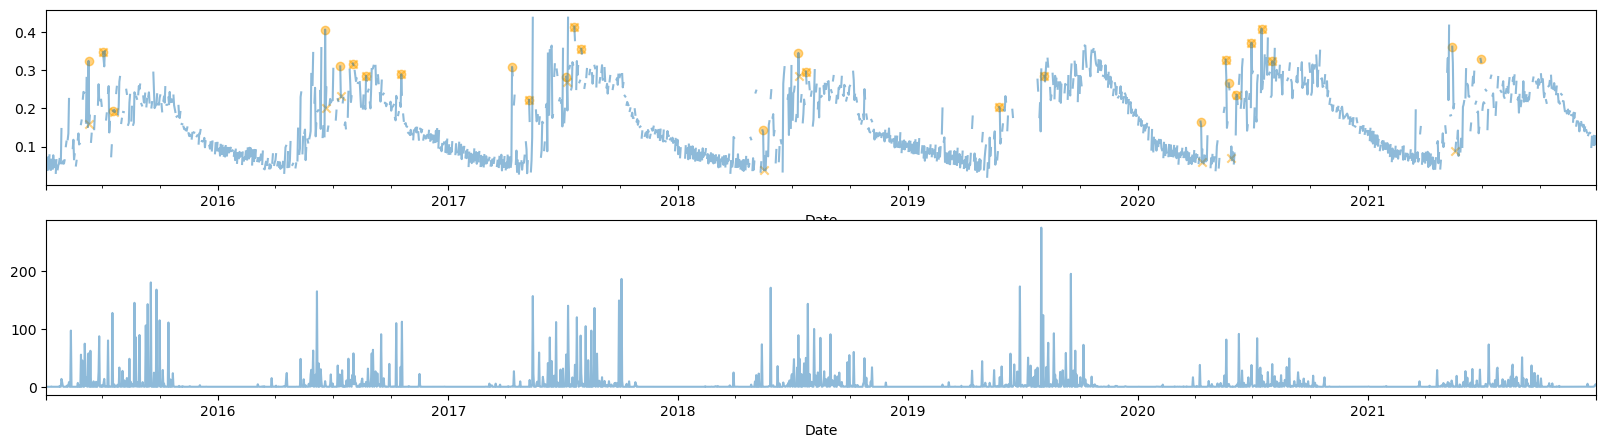

In [ ]:
fig, (ax11, ax12) = plt.subplots(2,1, figsize=(20, 5))
ds_synced.soil_moisture_daily.plot(ax=ax11, alpha=0.5)
ax11.scatter(ds_synced.soil_moisture_daily[ds_synced['event_start']].index, ds_synced.soil_moisture_daily[ds_synced['event_start']].values, color='orange', alpha=0.5)
ax11.scatter(ds_synced.soil_moisture_daily[ds_synced['event_end']].index, ds_synced.soil_moisture_daily[ds_synced['event_end']].values, color='orange', marker='x', alpha=0.5)
ds_synced.precip.plot(ax=ax12, alpha=0.5)
fig.savefig(os.path.join(output_path2, f'{target_station}_timeseries.png'))


(17897.0, 18260.0)

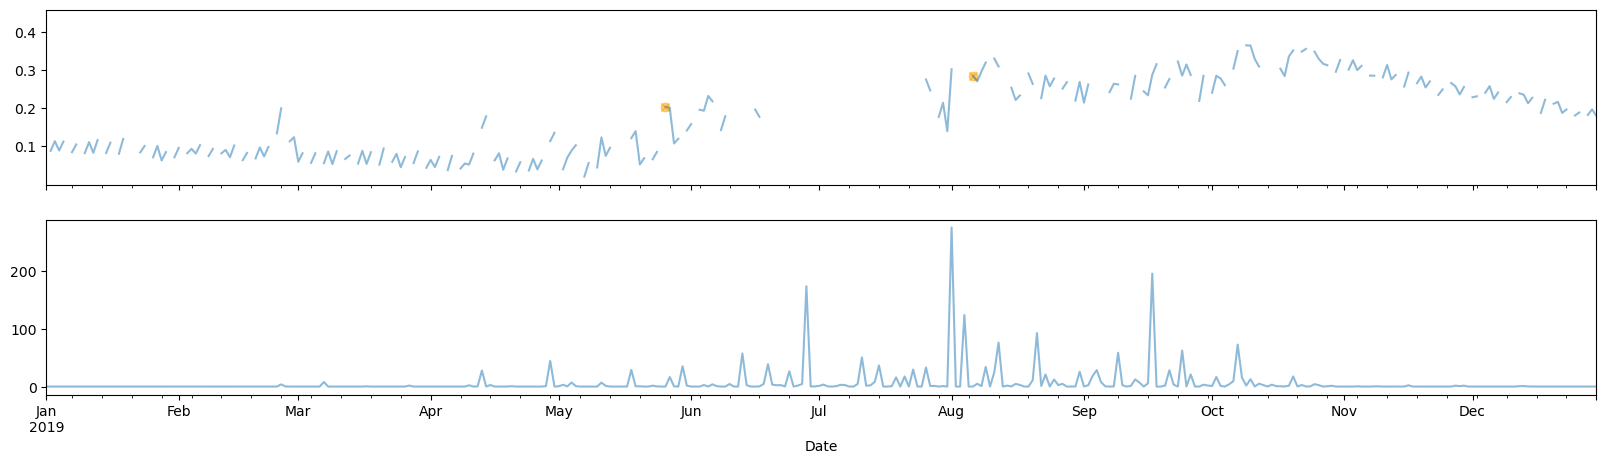

In [ ]:
fig2, (ax21, ax22) = plt.subplots(2,1, figsize=(20, 5), sharex=True)
ds_synced.soil_moisture_daily.plot(ax=ax21, alpha=0.5)
ax21.scatter(ds_synced.soil_moisture_daily[ds_synced['event_start']].index, ds_synced.soil_moisture_daily[ds_synced['event_start']].values, color='orange', alpha=0.5)
ax21.scatter(ds_synced.soil_moisture_daily[ds_synced['event_end']].index, ds_synced.soil_moisture_daily[ds_synced['event_end']].values, color='orange', marker='x', alpha=0.5)
ds_synced.precip.plot(ax=ax22, alpha=0.5)
ax22.set_xlim([datetime(2019, 1, 1), datetime(2019, 12, 30)])

In [ ]:
ds_synced['dSdt(t-1)'] = ds_synced.dSdt.shift(+1)
ds_synced.head(10)

,soil_moisture_daily,precip,PET,sm_for_dS_calc,dS,dt,dSdt,event_start,event_end,dSdt(t-1)
Date,,,,,,,,,,
2015-04-03,0.066951,0.00000,5.81677,0.066951,NaN,1.0,NaN,False,False,NaN
2015-04-04,NaN,0.00864,5.61718,0.066951,0.000000,1.0,-0.027858,False,False,NaN
2015-04-05,0.039093,0.00000,5.76695,0.039093,-0.027858,1.0,0.033631,False,False,-0.027858
2015-04-06,0.072724,0.00000,5.87288,0.072724,0.033631,1.0,-0.030846,False,False,0.033631
2015-04-07,0.041878,0.02592,6.63927,0.041878,-0.030846,1.0,0.035568,False,False,-0.030846
2015-04-08,0.077447,0.00000,5.60750,0.077447,0.035568,1.0,NaN,False,False,0.035568
2015-04-09,NaN,0.00000,5.77250,0.077447,0.000000,1.0,-0.038011,False,False,NaN
2015-04-10,0.039436,0.00000,6.14316,0.039436,-0.038011,1.0,0.026564,False,False,-0.038011
2015-04-11,0.066000,0.53568,5.37932,0.066000,0.026564,1.0,NaN,False,False,0.026564


## Separate into events

In [ ]:
start_indices = ds_synced[ds_synced['event_start']].index
end_indices = ds_synced[ds_synced['event_end']].index

# Create a new DataFrame with each row containing a list of soil moisture values between each pair of event_start and event_end
event_data = [{'event_start': start_index, 
               'event_end': end_index, 
               'soil_moisture_daily': list(ds_synced.loc[start_index:end_index, 'soil_moisture_daily'].values),
               'precip': list(ds_synced.loc[start_index:end_index, 'precip'].values),
               'PET': list(ds_synced.loc[start_index:end_index, 'PET'].values),
               #'LAI': list(ds_synced.loc[start_index:end_index, 'LAI'].values),
               #'NDVI': list(ds_synced.loc[start_index:end_index, 'NDVI'].values),
               'delta_theta': ds_synced.loc[start_index, 'dSdt(t-1)'],
                #'bulk_density': ds_synced.loc[start_index, 'bulk_density'],
                #'sand_fraction': ds_synced.loc[start_index, 'sand_fraction'],
                #'clay_fraction': ds_synced.loc[start_index, 'clay_fraction']
               } 
               for start_index, end_index in zip(start_indices, end_indices)]
event_df = pd.DataFrame(event_data)

In [ ]:
min_consective_days = 5
event_df_long = event_df[event_df['soil_moisture_daily'].apply(lambda x: pd.notna(x).sum()) >= min_consective_days].copy()
event_df_long = event_df_long.reset_index(drop=True)
event_df_long


,event_start,event_end,soil_moisture_daily,precip,PET,delta_theta
0,2021-05-15,2021-05-20,"[0.3617638, 0.3193378, 0.1997516, 0.2114278, n...","[6.06528, 0.0, 1.5119999999999998, 0.37152, 0....","[6.05425, 6.48087, 4.3175, 5.9352, 6.03887, 6....",0.179536
1,2021-06-29,2021-07-06,"[0.3299239, 0.3213757, nan, 0.196465, 0.211597...","[0.42335999999999996, 0.0, 0.00864, 0.02592, 1...","[1.32244, 3.91202, 5.16354, 4.27555, 4.44736, ...",0.180616


## Calculate tau & q

In [ ]:
from scipy.optimize import curve_fit
from scipy.stats import norm
from scipy.optimize import minimize

## Expontnetial model

In [ ]:
# Function for exponential model
def exp_model(t, delta_theta, theta_w, tau):
    return delta_theta * np.exp(-t/tau) + theta_w

def neg_log_likelihood(params, t, y):
    delta_theta, theta_w, tau, sigma = params
    y_hat = exp_model(t, delta_theta, theta_w, tau)
    residuals = y - y_hat
    ssr = np.sum(residuals ** 2)
    n = len(y)
    sigma2 = ssr / n
    ll = -(n / 2) * np.log(2 * np.pi * sigma2) - (1 / (2 * sigma2)) * ssr
    return -ll


In [ ]:
min_sm_values_at_the_pt = df_ts_sync.soil_moisture_smapL3.min()
min_sm_values_at_the_pt

0.0212449

In [ ]:
# Fit exponential model to each drydown event

opt_model = 'OLSE'
# opt_model = 'MLE'
drydown_params = []
for index, row in event_df_long.iterrows():
    start_date = row['event_start']
    end_date = row['event_end']
    delta_theta = row['delta_theta']
    soil_moisture_subset = np.asarray(row['soil_moisture_daily'])
    t = np.arange(0, len(soil_moisture_subset),1)
    soil_moisture_range = np.nanmax(soil_moisture_subset) - np.nanmin(soil_moisture_subset)
    soil_moisture_subset_min = np.nanmin(soil_moisture_subset)
    soil_moisture_subset_max = np.nanmax(soil_moisture_subset)
    x = t[~np.isnan(soil_moisture_subset)]
    y = soil_moisture_subset[~np.isnan(soil_moisture_subset)]
    #       delta_theta, theta_w, tau, sigma
    
    if opt_model == "MLE":
        bounds  = ((0, 2*soil_moisture_range), (min_sm_values_at_the_pt, soil_moisture_subset_min), (0, np.inf), (0, np.inf))
        p0      = [0.5*soil_moisture_subset_max, (min_sm_values_at_the_pt+soil_moisture_subset_min)/2, 1, 0.1]
        res = minimize(neg_log_likelihood, p0, args=(t[~np.isnan(soil_moisture_subset)], soil_moisture_subset[~np.isnan(soil_moisture_subset)]), bounds=bounds, method='L-BFGS-B')
        popt = res.x
        if res.success and res.fun < 0:
            drydown_params.append({'event_start': start_date, 'event_end': end_date, 'delta_theta': popt[0], 'theta_w': popt[1], 'tau': popt[2]})
    elif opt_model == 'OLSE':
        # exp_model(t, delta_theta, theta_w, tau):
        bounds  = [(0, min_sm_values_at_the_pt, 0), (2*soil_moisture_range, soil_moisture_subset_min, np.inf)]
        p0      = [0.5*soil_moisture_range, (soil_moisture_subset_min+min_sm_values_at_the_pt)/2, 1]
        try: 
            popt, pcov = curve_fit(f=exp_model, xdata=x, ydata=y, p0=p0, bounds=bounds)
            # popt: Optimal values for the parameters so that the sum of the squared residuals of f(xdata, *popt) - ydata is minimized
            # pcov: The estimated covariance of popt
            y_opt = exp_model(x, *popt)
            residuals = y - y_opt
            ss_res = np.sum(residuals ** 2)
            ss_tot = np.sum((y - np.nanmean(y)) ** 2)
            r_squared = 1 - (ss_res / ss_tot)

            drydown_params.append({'event_start': start_date, 'event_end': end_date, 'delta_theta': popt[0], 'theta_w': popt[1], 'tau': popt[2], 'r_squared': r_squared, 'opt_drydown': y_opt.tolist()})
        except:
            print('Error raised')
            continue

# Convert drydown parameters to DataFrame
drydown_params_df = pd.DataFrame(drydown_params)
drydown_params


[{'event_start': Timestamp('2021-05-15 00:00:00'),
  'event_end': Timestamp('2021-05-20 00:00:00'),
  'delta_theta': 0.35367378309213643,
  'theta_w': 0.021244900000000004,
  'tau': 3.711172590017104,
  'r_squared': 0.9266011373944723,
  'opt_drydown': [0.37491868309213644,
   0.2913789608955962,
   0.22757178750055143,
   0.17883622470939436,
   0.11318082818811628]},
 {'event_start': Timestamp('2021-06-29 00:00:00'),
  'event_end': Timestamp('2021-07-06 00:00:00'),
  'delta_theta': 0.1500633681994042,
  'theta_w': 0.19297349202107972,
  'tau': 2.184843452787898,
  'r_squared': 0.851340952789479,
  'opt_drydown': [0.3430368602204839,
   0.2879243015657412,
   0.23098776031219398,
   0.2170265676770451,
   0.20819278926181678,
   0.20260332114625695]}]

In [ ]:
event_df_with_curvefit = pd.merge(event_df_long, drydown_params_df.drop(columns='delta_theta'), on=['event_start', 'event_end'], how='outer')
event_df_with_curvefit

,event_start,event_end,soil_moisture_daily,precip,PET,delta_theta,theta_w,tau,r_squared,opt_drydown
0,2021-05-15,2021-05-20,"[0.3617638, 0.3193378, 0.1997516, 0.2114278, n...","[6.06528, 0.0, 1.5119999999999998, 0.37152, 0....","[6.05425, 6.48087, 4.3175, 5.9352, 6.03887, 6....",0.179536,0.021245,3.711173,0.926601,"[0.37491868309213644, 0.2913789608955962, 0.22..."
1,2021-06-29,2021-07-06,"[0.3299239, 0.3213757, nan, 0.196465, 0.211597...","[0.42335999999999996, 0.0, 0.00864, 0.02592, 1...","[1.32244, 3.91202, 5.16354, 4.27555, 4.44736, ...",0.180616,0.192973,2.184843,0.851341,"[0.3430368602204839, 0.2879243015657412, 0.230..."


## q model

In [ ]:
# Fit q model, solved by Bryn
def q_model(t, k, q, delta_theta, theta_star, theta_w):

    s0 = (delta_theta - theta_w)**(1-q)

    a = (1 - q) / ( ( theta_star - theta_w ) ** q )

    return (- k * a * t + s0 ) ** (1/(1-q)) + theta_w

# def exp_model(t, delta_theta, theta_w, tau):
#     return delta_theta * np.exp(-t/tau) + theta_w

In [ ]:
min_sm_values_at_the_pt = df_ts_sync.soil_moisture_smapL3.min()
min_sm_values_at_the_pt

0.0212449

In [ ]:
# Fit exponential model to each drydown event

opt_model = 'OLSE'
# opt_model = 'MLE'
drydown_params = []
for index, row in event_df_long.iterrows():
    start_date = row['event_start']
    end_date = row['event_end']
    delta_theta = row['delta_theta']
    soil_moisture_subset = np.asarray(row['soil_moisture_daily'])
    PET = np.average(row['PET'])
    t = np.arange(0, len(soil_moisture_subset),1)
    soil_moisture_range = np.nanmax(soil_moisture_subset) - np.nanmin(soil_moisture_subset)
    soil_moisture_subset_min = np.nanmin(soil_moisture_subset)
    soil_moisture_subset_max = np.nanmax(soil_moisture_subset)
    x = t[~np.isnan(soil_moisture_subset)]
    y = soil_moisture_subset[~np.isnan(soil_moisture_subset)]
    #       delta_theta, theta_w, tau, sigma
    
    if opt_model == "MLE":
        bounds  = ((0, 2*soil_moisture_range), (min_sm_values_at_the_pt, soil_moisture_subset_min), (0, np.inf), (0, np.inf))
        p0      = [0.5*soil_moisture_subset_max, (min_sm_values_at_the_pt+soil_moisture_subset_min)/2, 1, 0.1]
        res = minimize(neg_log_likelihood, p0, args=(t[~np.isnan(soil_moisture_subset)], soil_moisture_subset[~np.isnan(soil_moisture_subset)]), bounds=bounds, method='L-BFGS-B')
        popt = res.x
        if res.success and res.fun < 0:
            drydown_params.append({'event_start': start_date, 'event_end': end_date, 'delta_theta': popt[0], 'theta_w': popt[1], 'tau': popt[2]})
    elif opt_model == 'OLSE':
        # exp_model(t, delta_theta, theta_w, tau):
        # bounds  = [(0, min_sm_values_at_the_pt, 0), (2*soil_moisture_range, soil_moisture_subset_min, np.inf)]
        # p0      = [0.5*soil_moisture_range, (soil_moisture_subset_min+min_sm_values_at_the_pt)/2, 1]
        # q_model(t, k, q, delta_theta, theta_star, theta_w=0)
        # custom_q_model = lambda x, mu: q_model(x, mu, 0.05)
        epsilon = 1.0E-10
        bounds  = [(0., 0., 0., 0., 0), (PET*10, 10, 1., 1., 1.)]
        p0      = [PET, 1. + 1.E-03, soil_moisture_range, 0.5, 1.0E-5]
        try: 
            popt, pcov = curve_fit(f=q_model, xdata=x, ydata=y, p0=p0, bounds=bounds)
            # popt: Optimal values for the parameters so that the sum of the squared residuals of f(xdata, *popt) - ydata is minimized
            # pcov: The estimated covariance of popt
            y_opt = q_model(x, *popt)
            residuals = y - y_opt
            ss_res = np.sum(residuals ** 2)
            ss_tot = np.sum((y - np.nanmean(y)) ** 2)
            r_squared = 1 - (ss_res / ss_tot)

            drydown_params.append({'event_start': start_date, 'event_end': end_date, 'q__k': popt[0], 'q__q': popt[1], 'q__delta_theta': popt[2], 'q__theta_star': popt[3], 'q__theta_w': popt[4], 'q__r_squared': r_squared, 'q__opt_drydown': y_opt.tolist()})
        except:
            print('Error raised')
            continue

# Convert drydown parameters to DataFrame
drydown_params_df = pd.DataFrame(drydown_params)
drydown_params

Error raised


[{'event_start': Timestamp('2021-05-15 00:00:00'),
  'event_end': Timestamp('2021-05-20 00:00:00'),
  'q__k': 0.10096406408105499,
  'q__q': 0.3939560366555389,
  'q__delta_theta': 0.36470907563887034,
  'q__theta_star': 0.999987114158784,
  'q__theta_w': 2.826236371142399e-11,
  'q__r_squared': 0.941744336745989,
  'q__opt_drydown': [0.36470907563887034,
   0.29937293123808134,
   0.2392266040561788,
   0.18452401384602135,
   0.09277189596794116]}]

In [ ]:
event_df_with_curvefit = pd.merge(event_df_with_curvefit, drydown_params_df, on=['event_start', 'event_end'], how='outer')
event_df_with_curvefit

,event_start,event_end,soil_moisture_daily,precip,PET,delta_theta,theta_w,tau,r_squared,opt_drydown,q__k,q__q,q__delta_theta,q__theta_star,q__theta_w,q__r_squared,q__opt_drydown
0,2021-05-15,2021-05-20,"[0.3617638, 0.3193378, 0.1997516, 0.2114278, n...","[6.06528, 0.0, 1.5119999999999998, 0.37152, 0....","[6.05425, 6.48087, 4.3175, 5.9352, 6.03887, 6....",0.179536,0.021245,3.711173,0.926601,"[0.37491868309213644, 0.2913789608955962, 0.22...",0.100964,0.393956,0.364709,0.999987,2.826236e-11,0.941744,"[0.36470907563887034, 0.29937293123808134, 0.2..."
1,2021-06-29,2021-07-06,"[0.3299239, 0.3213757, nan, 0.196465, 0.211597...","[0.42335999999999996, 0.0, 0.00864, 0.02592, 1...","[1.32244, 3.91202, 5.16354, 4.27555, 4.44736, ...",0.180616,0.192973,2.184843,0.851341,"[0.3430368602204839, 0.2879243015657412, 0.230...",NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Plot

In [ ]:
row

event_start                                          2021-06-29 00:00:00
event_end                                            2021-07-06 00:00:00
soil_moisture_daily    [0.3299239, 0.3213757, nan, 0.196465, 0.211597...
precip                 [0.42335999999999996, 0.0, 0.00864, 0.02592, 1...
PET                    [1.32244, 3.91202, 5.16354, 4.27555, 4.44736, ...
delta_theta                                                     0.180616
Name: 1, dtype: object

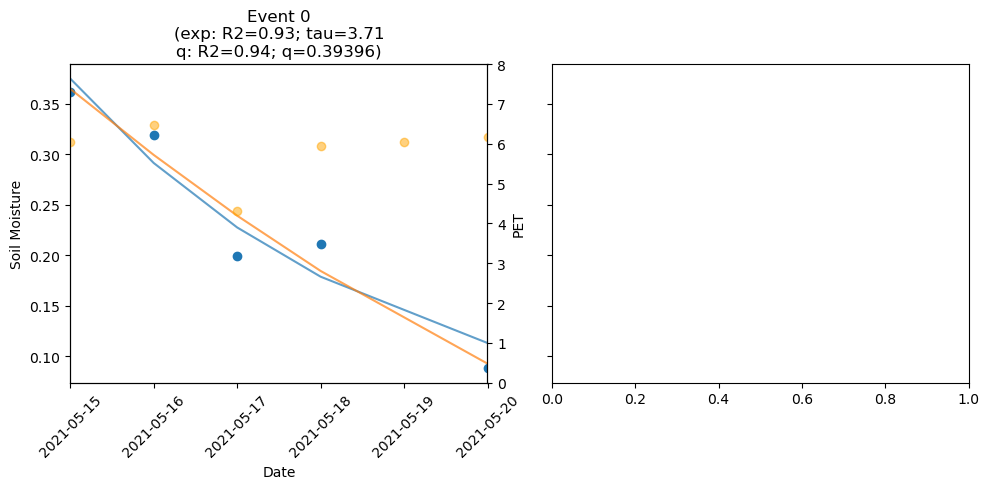

In [ ]:
# Convert the event start/end columns to datetime format
event_df_with_curvefit['event_start'] = pd.to_datetime(event_df_long['event_start'])
event_df_with_curvefit['event_end'] = pd.to_datetime(event_df_long['event_end'])

# Determine the number of columns needed for the subplots grid
num_events = len(event_df_with_curvefit)
num_cols = 2
num_rows = int(num_events / num_cols) + int(num_events % num_cols != 0)

# Plot each row of the event DataFrame as a time series
fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, sharey=True, figsize=(10, 5))
for index, row in event_df_with_curvefit.iterrows():

    x = pd.date_range(start=row['event_start'], end=row['event_end'], freq='D')
    y = np.asarray(row['soil_moisture_daily'])
    y_opt = np.asarray(row['opt_drydown'])
    y_opt__q = np.asarray(row['q__opt_drydown'])
    y2 = row['PET']
    t = np.arange(0, len(row['soil_moisture_daily']),1)
    r_squared = row['r_squared']
    q__r_squared = row['q__r_squared']
    q = row['q__q']
    tau = row['tau']
    try:
        ax_row = int(index / num_cols)
        ax_col = index % num_cols
        axes[ax_row, ax_col].scatter(x, y)
        axes[ax_row, ax_col].plot(x[~np.isnan(y)], y_opt, alpha=.7)
        axes[ax_row, ax_col].plot(x[~np.isnan(y)], y_opt__q, alpha=.7)
        ax2 = axes[ax_row, ax_col].twinx()
        ax2.scatter(x, y2, color='orange', alpha=.5)
        axes[ax_row, ax_col].set_title(f'Event {index}\n(exp: R2={r_squared:.2f}; tau={tau:.2f}\nq: R2={q__r_squared:.2f}; q={q:.5f})')
        axes[ax_row, ax_col].set_xlabel('Date')
        axes[ax_row, ax_col].set_ylabel('Soil Moisture')
        axes[ax_row, ax_col].set_xlim([row['event_start'], row['event_end']])
        ax2.set_ylim([0, 8])
        ax2.set_ylabel('PET')
        # Rotate the x tick labels
        axes[ax_row, ax_col].tick_params(axis='x', rotation=45)
    except:
        try:
            ax_row = int(index / num_cols)
            ax_col = index % num_cols
            axes[ax_row].scatter(x, y)
            axes[ax_row].plot(x[~np.isnan(y)], y_opt, alpha=.7)
            axes[ax_row].plot(x[~np.isnan(y)], y_opt__q, alpha=.7)
            ax2 = axes[ax_row].twinx()
            ax2.scatter(x, y2, color='orange', alpha=.5)
            axes[ax_row].set_title(f'Event {index}\n(exp: R2={r_squared:.2f}; tau={tau:.2f}\nq: R2={q__r_squared:.2f}; q={q:.5f})')
            axes[ax_row].set_xlabel('Date')
            axes[ax_row].set_ylabel('Soil Moisture')
            axes[ax_row].set_xlim([row['event_start'], row['event_end']])
            ax2.set_ylim([0, 8])
            ax2.set_ylabel('PET')
            # Rotate the x tick labels
            axes[ax_row].tick_params(axis='x', rotation=45)
        except:
            continue
        continue

fig.tight_layout()
fig.show()
fig.savefig(os.path.join(output_path2, f'{target_station}_events.png'))


In [ ]:
event_df_with_curvefit.to_csv(os.path.join(output_path2, f'event_df_with_curvefit.csv'), index=True)